# Examining the effects of ownership on software quality

## The Case Of Lucene##
We want to replicate the study (http://dl.acm.org/citation.cfm?doid=2025113.2025119) done by Bird et al.
and published in FSE'11. The idea is to see the results of a similar investigation on an OSS system. We
select Lucene (https://lucene.apache.org/core/), a search engine written in Java.

## Data collection##
First we need to get the data to create our table, in other words we do what is called data collection.

In our case, we are interested in checking the relation between some ownership related metrics and post-
release bugs. We investigate this relation at file level, because we focus on Java and in this language the
building blocks are the classes, which most of the time correspond 1-to-1 to files.

This means that our table will have one row per each source code file and as many columns as the metrics
we want to compute for that file, plus one column with the number of post release bugs.


## Collecting git data
For computing most of the metrics we want to investigate (e.g., how many people changed a file in its entire
history) we need to know the history of files. We can do so by analyzing the versioning system. In our case,
Lucene has a Subversion repository, but a git mirror (https://github.com/apache/lucene-solr.git) is also
available. We use the git repository as it allows to have the entire history locally, thus making the
computations faster.

We clone the repository. For this we use the python library 'sh'.


In [1]:
%matplotlib inline

import sh
import json
import os
import glob2
from collections import Counter
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists(os.getcwd() + '/lucene-solr'):
    print("Path doesn\'t exists, cloning repo:")
    sh.git.clone("https://github.com/apache/lucene-solr.git")
else:
    print("Repository exists")

Repository exists


In [3]:
git = sh.git.bake(_cwd='lucene-solr')
git.status()

HEAD detached at lucene_solr_3_1
nothing to commit, working directory clean

To perform the replication, we can either reason in terms of releases (see list of Lucene releases
(http://archive.apache.org/dist/lucene/java/)), or we can just inspect the 'trunk' in the versioning system and
start from a given date.

**We decided to reason in terms of releases**.

We first check which releases can be found in the git repository: 

In [4]:
tags = git.tag() # To show all the tags
versions = []
for t in tags:
    if t.startswith('lucene_solr_'):
        versions.append(t[12:-1].replace('_','.')) #extract the version, remove the \n

In [5]:
git.checkout("tags/lucene_solr_3_1")
git.status()

HEAD detached at lucene_solr_3_1
nothing to commit, working directory clean

In [6]:
def extract_features(parent, child):
    feature_list = []
    data = git.diff("--numstat", "-b", "-w",parent, child) # -w: ignore blanklines,
    
    author = git("--no-pager","show", "-s", "--pretty=format:%an <%ae>", parent)
    commitId = git("rev-parse", parent)

    data = data.split('\n')
    for d in data:
        feature = d.split('\t')   
        if not(feature[-1].find('.java') == -1):
            feature_list.append([commitId , author] + feature )

    return feature_list

In [7]:
HEAD = git.log("-1", "--pretty=format:%H")

numberOfCommits = git("rev-list",HEAD, "--count")
feature_list = []
i = 1
while i < int(numberOfCommits):
    parent = str(HEAD) + "~" + str(i)
    child = str(HEAD) + "~" + str(i-1)
    
    feature = extract_features(parent, child)
    if len(feature) > 0:
        feature_list += feature
    
    i+=1
    if i % 50 == 0:
        print(i)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250


In [8]:
df = pd.DataFrame(feature_list, columns=["Commit Hash", "Author", "Lines Added", "Lines Deleted", "File"]) 
df[['Lines Added','Lines Deleted']] = df[['Lines Added','Lines Deleted']].astype(int)


### Output data to file

In [9]:
df.to_csv('Output_data.csv')

In [10]:
df = pd.read_csv('Output_data.csv');

In [11]:
df.describe()

,Unnamed: 0,Lines Added,Lines Deleted
count,9532.000000,9532.000000,9532.000000
mean,4765.500000,76.064834,18.915128
std,2751.795717,207.785831,115.099592
min,0.000000,0.000000,0.000000
25%,2382.750000,1.000000,0.000000
50%,4765.500000,8.000000,1.000000
75%,7148.250000,78.000000,3.000000
max,9531.000000,5034.000000,4861.000000


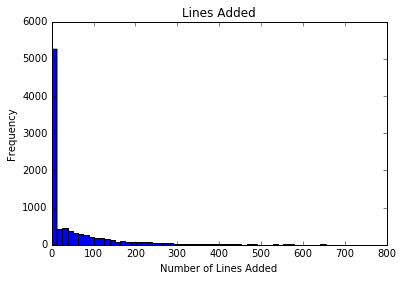

In [52]:
plt.hist(df['Lines Added'], 400)
plt.axis([0, 800,0,6000])

# plt.hist(df['Lines Added'])
# plt.yscale('log', nonposy='clip')

plt.title("Lines Added")
plt.xlabel("Number of Lines Added")
plt.ylabel("Frequency")

plt.show()

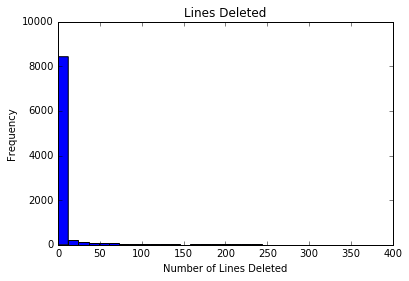

In [54]:
plt.hist(df['Lines Deleted'],400)
plt.axis([0, 400,0,10000])

# plt.hist(df['Lines Deleted'])
# plt.yscale('log', nonposy='clip')

plt.title("Lines Deleted")
plt.xlabel("Number of Lines Deleted")
plt.ylabel("Frequency")
plt.show()

In [48]:
percentage = len(df[df['Lines Added'] > 100])/len(df['Lines Added']) * 100

print("Percentage of commits with more than 100 lines added is: " + str(percentage))

Percentage of commits with more than 100 lines added is: 20.478388585816198


In [63]:
percentage = len(df[df['Lines Added'] < 10])/len(df['Lines Added']) * 100

print("Percentage of commits with less than 20 lines added is: " + str(percentage))

Percentage of commits with less than 20 lines added is: 52.12966848510281
